## *Statistics coded:* Living conditions in Europe - poverty and social exclusion

Prepared by [**Lasai Barreñada**](https://github.com/LasaiBarrenada) (EMOS).

This notebook aims at illustrating the *Statistics Expplained* article on [Living conditions in Europe - poverty and social exclusion](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Living_conditions_in_Europe_-_poverty_and_social_exclusion).


### Settings

The libraries needed for this notebook are the following ones:

In [1]:
import numpy as np
from eurostatapiclient import EurostatAPIClient
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
import math



### Documentation:
- [**Numpy**](https://numpy.org/)
- [**EurostatApiClient**](https://pypi.org/project/eurostatapiclient/)
- [**Matplotlib**](https://matplotlib.org/contents.html)
- [**Seaborn**](https://seaborn.pydata.org/)

#### Set up eurostatapiclinet by supplying settings, which will stay the same throught

In [2]:
VERSION = 'v2.1'
FORMAT = 'json'
LANGUAGE = 'en'
client = EurostatAPIClient(VERSION, FORMAT, LANGUAGE)

legend_properties = {'weight':'bold','size':'10'}
countries_names = {'AT':'Austria', 'BE':'Belgium', 'BG':'Bulgaria', 'CY': 'Cyprus', 'CZ': 'Czechia', 'DE': 'Germany', 'DK':
            'Denmark', 'EE':'Estonia', 'EL': 'Greece', 'ES':'Spain', 'FI':'Finland', 'FR':'France', 'HR':'Croatia', 
            'HU':'Hungary', 'IE':'Ireland', 'IT':'Italy', 'LT':'Lithuania', 'LU':'Luxembourg', 'LV':'Latvia', 'MT':
            'Malta', 'NL':'Netherlands', 'PL':'Poland', 'PT':'Portugal', 'RO':'Romania', 'SE':'Sweden', 'SI':'Slovenia',
            'SK':'Slovakia', 'UK':'United Kingdom', 'EU28': 'EU-28', 'TR':'Turkey','CH':'Switzerland', 'IS':'Iceland', 'MK':'North Macedonia','ME':'MONTENEGRO',
            'NO':'Norway', 'RS': 'Serbia'}
countries_abbr = ['AT','BE','BG','CY','CZ','DE','DK','EE','EL','ES','FI',
                  'FR','HR','HU','IE','IT','LT','LU','LV','NV','NL','PL','PT','RO','SE','SI','SK','UK','MT', 'EU28']


In [3]:
def setvaluegraph (value #list of the values 
                   ,axis #Axis where we represent the value
                   , horizontal #True if the graph is horizontal and False if it's vertical 
                   ,xpos = 0 # Parameter to adjust the position of the value on x axis
                   ,ypos= 0 # Parameter to adjust the position of the value on y axis
                   , fontsize= 8
                   , color = 'b'
                   , weight = 'normal'
                   , style = 'normal'
                   , form = '{}'): #Format of the desired value e.g {:.1f}% for pcg
    if horizontal:
         for i,v in enumerate(value):
             axis.text(v-xpos,i-ypos,str(form.format(v)), fontsize = fontsize, color = color, weight = weight, style = style)
    else:
        for i,v in enumerate(value):
            axis.text(i-xpos,v-ypos,str(form.format(v)), fontsize = fontsize, color = color, weight = weight, style = style)
# This function allows to set the value of the represented graph

### Poverty and social exclusion

#### Figure 1

Text(0.3, 1, 'People at risk of porverty or social exclusion in EU, 2008-2018 \n (in million persons and % of total population, 2020 data)')

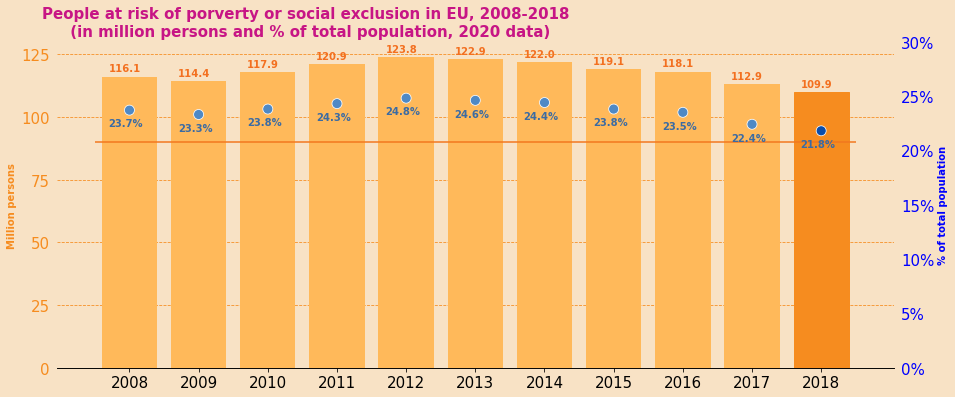

In [4]:
#We define params of dataframes
params_df1_ths_per = {
    'AGE': 'TOTAL',
    'sinceTimePeriod': '2008',
    'sex': 'T',
    'geo':'EU',
    'unit':'THS_PER'
} 
params_df1_pc = {
    'AGE': 'TOTAL',
    'sinceTimePeriod': '2008',
    'sex': 'T',
    'geo':'EU',
    'unit':'PC'
} 
# We retrieve the info with the EurostatApiClient
dataframe_1_ths_per = client.get_dataset('ilc_peps01', params=params_df1_ths_per).to_dataframe()
dataframe_1_pc = client.get_dataset('ilc_peps01', params=params_df1_pc).to_dataframe()
params_df1_ths_per.update({'lastTimePeriod': '2018'})
dataframe_1_ths_per = dataframe_1_ths_per[dataframe_1_ths_per.time <= params_df1_ths_per['lastTimePeriod']]
params_df1_pc.update({'lastTimePeriod': '2018'})
dataframe_1_pc = dataframe_1_pc[dataframe_1_pc.time <= params_df1_pc['lastTimePeriod']]
dataframe_1_ths_per = dataframe_1_ths_per.pivot(index='time', columns='age', values='values').reset_index()
dataframe_1_pc = dataframe_1_pc.pivot(index='time', columns='age', values='values').reset_index()

values = dataframe_1_ths_per['TOTAL']

fig = plt.figure(facecolor='#f8e2c5', figsize = (15,6)) #We create the figure
ax=fig.add_subplot(facecolor='#f8e2c5')

barplot =ax.bar(dataframe_1_ths_per['time'],dataframe_1_ths_per['TOTAL']/1000, color=('#ffb95a')) #We draw the barplot with the first dataframe
barplot[10].set_color('#f68c1f') #Highlight the 10th bar

axes1 = plt.gca() 
axes2 = axes1.twinx() #We create the secondary axis with twinx
scatterplot= sns.scatterplot(x=dataframe_1_pc['time'], #We draw the scatterplot and specify the arguments
                             y = dataframe_1_pc['TOTAL'],
                             hue= dataframe_1_pc['time'],
                             ax=axes2 ,
                             s = 100 ,
                             palette=['#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#0b4dab'],
                             legend = False)
# We set the ticks of both axis
axes2.set_yticks(range(0,31,5))
axes1.set_yticks(range(0,151,25))
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks =  mtick.FormatStrFormatter(fmt)
axes2.yaxis.set_major_formatter(yticks) #We set the ticks of the right axis in percentage
ax.tick_params(axis = "y", which = "both", bottom = False, top = False, left = False, right=False, colors = '#f68c1f' , labelsize = 15)
ax.tick_params(axis ='x', which = 'both', labelsize = 15)
axes2.tick_params(axis='y',right=False, colors = 'b', labelsize = 15)
ax.yaxis.label.set_color('#f68c1f')
ax.set_ylabel('Million persons', weight = 'bold')
axes2.yaxis.label.set_color('b')
axes2.set_ylabel('% of total population' , weight = 'bold')
ax.set_axisbelow(True)

ax.hlines(values[10]/1000-20,-0.5,10.5, colors='#f2771e') #Horizontal line with the last value minus 20 million

#Set the values in the graph with the function defined above
setvaluegraph(round(dataframe_1_ths_per['TOTAL']/1000,1),ax,False,0.3,-2,10,color='#f37020',weight='bold')
setvaluegraph(dataframe_1_pc['TOTAL'],axes2,False,0.3,1.5,10,color='#3b6ba3',weight = 'bold', form ='{:.1f}%' )

ax.grid(True, which = 'major', axis = 'y' , color ='#f68c1f', linestyle = '--' )
sns.despine(top=True, right=True, left=True, bottom=False)

ax.set_title('People at risk of porverty or social exclusion in {}, {}-{} \n (in million persons and % of total population, 2020 data)'.format(params_df1_ths_per['geo'],params_df1_ths_per['sinceTimePeriod'],params_df1_ths_per['lastTimePeriod']),
             fontsize=15,fontweight='bold',y=1, x=0.3, c = 'mediumvioletred')


![Figure 1: People at risk of poverty or social exclusion, 2008-2018(EU-28, million persons)](https://ec.europa.eu/eurostat/statistics-explained/images/f/fe/People_at_risk_of_poverty_or_social_exclusion%2C_2008-2018_2.jpeg)

Figure 1: People at risk of poverty or social exclusion, 2008-2018 (EU-28, million persons)

Source: Eurostat ([ilc_peps01](https://appsso.eurostat.ec.europa.eu/nui/show.do?query=BOOKMARK_DS-127829_QID_109B0E0E_UID_-3F171EB0&layout=TIME,C,X,0;GEO,L,Y,0;UNIT,L,Z,0;AGE,L,Z,1;SEX,L,Z,2;INDICATORS,C,Z,3;&zSelection=DS-127829UNIT,PC;DS-127829AGE,Y16-29;DS-127829SEX,T;DS-127829INDICATORS,OBS_FLAG;&rankName1=UNIT_1_2_-1_2&rankName2=AGE_1_2_-1_2&rankName3=INDICATORS_1_2_-1_2&rankName4=SEX_1_2_-1_2&rankName5=TIME_1_0_0_0&rankName6=GEO_1_2_0_1&sortC=ASC_-1_FIRST&rStp=&cStp=&rDCh=&cDCh=&rDM=true&cDM=true&footnes=false&empty=false&wai=false&time_mode=ROLLING&time_most_recent=false&lang=EN&cfo=%23%23%23,%23%23%23.%23%23%23&lang=en))



 # **Figure 2**
![Figure 2: People at risk of poverty or social exclusion by socio-economic characteristic, 2018](https://ec.europa.eu/eurostat/statistics-explained/images/8/80/People_at_risk_of_poverty_or_social_exclusion_by_socio-economic_characteristic%2C_2018_3.png)

Figure 2: People at risk of poverty or social exclusion by socio-economic characteristic, 2018
(% share of the total population)

Source: Eurostat ([ilc_peps01](https://appsso.eurostat.ec.europa.eu/nui/show.do?query=BOOKMARK_DS-127829_QID_109B0E0E_UID_-3F171EB0&layout=TIME,C,X,0;GEO,L,Y,0;UNIT,L,Z,0;AGE,L,Z,1;SEX,L,Z,2;INDICATORS,C,Z,3;&zSelection=DS-127829UNIT,PC;DS-127829AGE,Y16-29;DS-127829SEX,T;DS-127829INDICATORS,OBS_FLAG;&rankName1=UNIT_1_2_-1_2&rankName2=AGE_1_2_-1_2&rankName3=INDICATORS_1_2_-1_2&rankName4=SEX_1_2_-1_2&rankName5=TIME_1_0_0_0&rankName6=GEO_1_2_0_1&sortC=ASC_-1_FIRST&rStp=&cStp=&rDCh=&cDCh=&rDM=true&cDM=true&footnes=false&empty=false&wai=false&time_mode=ROLLING&time_most_recent=false&lang=EN&cfo=%23%23%23,%23%23%23.%23%23%23&lang=en))
, ([ilc_peps02](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_peps02&lang=en))
 and ([ilc_peps04](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_peps04&lang=en))

Text(13.5, 65, 'Activity status')

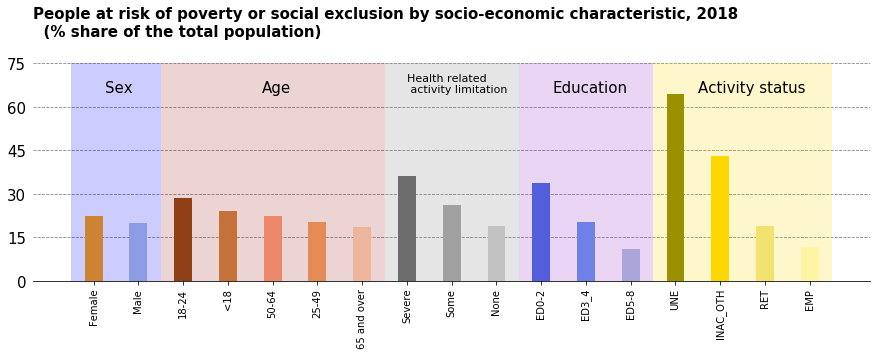

In [5]:

dataframe_2_sex_query = 'ilc_peps01?precision=2&sex=F&sex=M&geo=EU&unit=PC&unitLabel=code&time=2018&age=Y_GE18'
dataframe_2_age_query = 'ilc_peps01?precision=1&sex=T&geo=EU&unit=PC&unitLabel=code&time=2018&age=Y18-24&age=Y25-49&age=Y50-64&age=Y_GE65&age=Y_LT18'
dataframe_2_lim_query = 'hlth_dpe010?sex=T&precision=1&lev_limit=NONE&lev_limit=SEV&lev_limit=SOME&geo=EU&unit=PC&time=2018&age=Y_GE16'
dataframe_2_activity_query = 'ilc_peps02?precision=1&sex=T&geo=EU&wstatus=EMP&wstatus=INAC_OTH&wstatus=RET&wstatus=UNE&time=2018&age=Y_GE18'
dataframe_2_education_query = 'ilc_peps04?precision=1&sex=T&geo=EU&isced11=ED0-2&isced11=ED3_4&isced11=ED5-8&time=2018&age=Y_GE18'


dataframe_2_sex = client.get_dataset(dataframe_2_sex_query).to_dataframe().sort_values(by = ['values'],ascending = False).replace(to_replace = ['F','M'], value = ['Female','Male'] )
dataframe_2_age =client.get_dataset(dataframe_2_age_query).to_dataframe().sort_values(by = ['values'],ascending = False).replace(to_replace = ['Y18-24','Y_LT18','Y50-64','Y25-49','Y_GE65'],value = ['18-24','<18','50-64','25-49','65 and over'])
dataframe_2_lim =client.get_dataset(dataframe_2_lim_query).to_dataframe().sort_values(by = ['values'],ascending = False).replace(to_replace = ['SEV','SOME','NONE'], value = ['Severe','Some', 'None'])
dataframe_2_activity =client.get_dataset(dataframe_2_activity_query).to_dataframe().sort_values(by = ['values'],ascending = False).replace(to_replace = ['ED0-2','ED3_4','ED5-8'],value = ['Low','Medium','High'])
dataframe_2_education =client.get_dataset(dataframe_2_education_query).to_dataframe().sort_values(by = ['values'],ascending = False).replace(to_replace = ['UNE','INAC_OTH','RET','EMP'], value = ['Unemployed','Other inactive','Retired','Employed'])


fig, ax = plt.subplots(figsize=(15, 4))

bar_sex = plt.bar(dataframe_2_sex['sex'],dataframe_2_sex['values'], color = ['orange','lightsteelblue'], width = 0.4 )
bar_age = plt.bar(dataframe_2_age['age'],dataframe_2_age['values'], color =['saddlebrown','peru','lightsalmon', 'sandybrown','peachpuff'], width = 0.4  )
bar_lim = plt.bar(dataframe_2_lim['lev_limit'],dataframe_2_lim['values'], color = ['dimgray','darkgray','lightgray'], width = 0.4 )
bar_education = plt.bar(dataframe_2_education['isced11'],dataframe_2_education['values'], color = ['royalblue','cornflowerblue','lightsteelblue'], width = 0.4 )
bar_activity = plt.bar(dataframe_2_activity['wstatus'],dataframe_2_activity['values'], color = ['olive','gold','khaki','lemonchiffon'], width = 0.4 )

ax.set_yticks(range(0,76,15))
ax.tick_params(axis = "y", which = "both", bottom = False, top = False, left = False, right=False, labelsize = 15)
sns.despine(top=True, right=True, left=True, bottom=False)
ax.grid(True, which = 'major', axis = 'y' , color ='grey', linestyle = '--')
ax.set_axisbelow(True)
plt.xticks(rotation= 90)

ax.set_title('People at risk of poverty or social exclusion by socio-economic characteristic, 2018 \n  (% share of the total population)' 
             , fontsize=15,fontweight='bold', horizontalalignment = 'left', x = 0, y =1.1)


plt.axvspan(-.5, 1+.5, facecolor='b', alpha=0.2)
plt.axvspan(1.5,6.5, facecolor='brown', alpha=0.2)
plt.axvspan(6.5,9.5, facecolor='grey', alpha=0.2)
plt.axvspan(9.5,12.5, facecolor='darkorchid', alpha=0.2)
plt.axvspan(12.5, 16.5, facecolor='gold', alpha=0.2)
plt.text( 0.25,65,'Sex', fontsize=15)
plt.text(3.75,65,'Age', fontsize=15)
plt.text(7,65,'Health related \n activity limitation', fontsize=11)
plt.text( 10.25,65,'Education', fontsize=15)
plt.text( 13.5,65,'Activity status', fontsize=15)


 # **Figure 3**
![Figure 3: People at risk of poverty or social exclusion by degree of urbanisation, 2018
(% share of the total population)](https://ec.europa.eu/eurostat/statistics-explained/images/2/26/People_at_risk_of_poverty_or_social_exclusion_by_degree_of_urbanisation%2C_2018_2.png)
Figure 3: People at risk of poverty or social exclusion by degree of urbanisation, 2018
(% share of the total population)

Source: Eurostat ([ilc_peps01](https://appsso.eurostat.ec.europa.eu/nui/show.do?query=BOOKMARK_DS-127829_QID_109B0E0E_UID_-3F171EB0&layout=TIME,C,X,0;GEO,L,Y,0;UNIT,L,Z,0;AGE,L,Z,1;SEX,L,Z,2;INDICATORS,C,Z,3;&zSelection=DS-127829UNIT,PC;DS-127829AGE,Y16-29;DS-127829SEX,T;DS-127829INDICATORS,OBS_FLAG;&rankName1=UNIT_1_2_-1_2&rankName2=AGE_1_2_-1_2&rankName3=INDICATORS_1_2_-1_2&rankName4=SEX_1_2_-1_2&rankName5=TIME_1_0_0_0&rankName6=GEO_1_2_0_1&sortC=ASC_-1_FIRST&rStp=&cStp=&rDCh=&cDCh=&rDM=true&cDM=true&footnes=false&empty=false&wai=false&time_mode=ROLLING&time_most_recent=false&lang=EN&cfo=%23%23%23,%23%23%23.%23%23%23&lang=en)) and ([ilc_peps13](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_peps13&lang=en))

Text(0, 1.05, 'People at risk of poverty or social exclusion by degree of urbanisation, 2018 \n  (% share of the total population)')

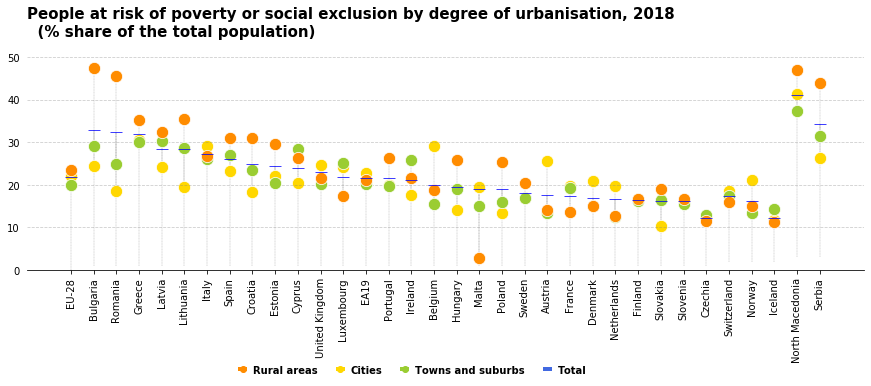

In [8]:

dataframe_3_query_total = 'ilc_peps01?precision=1&sex=T&geo=AT&geo=BE&geo=BG&geo=CH&geo=CY&geo=CZ&geo=DK&geo=EA19&geo=EE&geo=EL&geo=ES&geo=EU28&geo=FI&geo=FR&geo=HR&geo=HU&geo=IE&geo=IS&geo=IT&geo=LT&geo=LU&geo=LV&geo=MK&geo=MT&geo=NL&geo=NO&geo=PL&geo=PT&geo=RO&geo=RS&geo=SE&geo=SI&geo=SK&geo=UK&unit=PC&unitLabel=label&time=2018&time=2017&time=2016&age=TOTAL'
dataframe_3_query_urb = 'ilc_peps13?precision=1&deg_urb=DEG1&deg_urb=DEG2&deg_urb=DEG3&geo=AT&geo=BE&geo=BG&geo=CH&geo=CY&geo=CZ&geo=DE&geo=DK&geo=EA19&geo=EE&geo=EL&geo=ES&geo=EU28&geo=FI&geo=FR&geo=HR&geo=HU&geo=IE&geo=IS&geo=IT&geo=LT&geo=LU&geo=LV&geo=MK&geo=MT&geo=NL&geo=NO&geo=PL&geo=PT&geo=RO&geo=RS&geo=SE&geo=SI&geo=SK&geo=UK&unit=PC&unitLabel=label&time=2018&time=2017&time=2016'


dataframe_3_total = client.get_dataset(dataframe_3_query_total).to_dataframe().replace({'geo':countries_names})
dataframe_3_total_2018 = dataframe_3_total[dataframe_3_total['time']=='2018']
dataframe_3_total_EU = dataframe_3_total_2018[(dataframe_3_total_2018['geo']=='EU-28') | (dataframe_3_total_2018['geo']== 'EA19')].pivot(index = 'geo', columns = 'age', values = 'values')
dataframe_3_total_2018 = dataframe_3_total_2018.pivot(index = 'geo', columns = 'age', values = 'values')
dataframe_3_urb = client.get_dataset(dataframe_3_query_urb).to_dataframe().replace({'geo':countries_names})#
dataframe_3_urb_2018 = dataframe_3_urb.loc[dataframe_3_urb['time']=='2018'].pivot(index = 'geo', columns = 'deg_urb', values = 'values')



if dataframe_3_total_2018['TOTAL'].isnull().values.any():
    for i, row in dataframe_3_total_2018.iterrows():
        if math.isnan(row['TOTAL']) :
          value = dataframe_3_total[dataframe_3_total['geo']==str(i) ].dropna().iloc[0,0]
          dataframe_3_total_2018.at[str(i),'TOTAL']= value
if dataframe_3_urb_2018['DEG1'].isnull().values.any() | dataframe_3_urb_2018['DEG2'].isnull().values.any() | dataframe_3_urb_2018['DEG3'].isnull().values.any():
    for i, row in dataframe_3_urb_2018.iterrows():
        if math.isnan(row['DEG1']) :
          value = dataframe_3_urb[(dataframe_3_urb['geo']==str(i)) & (dataframe_3_urb['deg_urb']== 'DEG1') ].dropna().iloc[0,0]
          dataframe_3_urb_2018.at[str(i),'DEG1'] = value
        if math.isnan(row['DEG2']) :
            value = dataframe_3_urb[(dataframe_3_urb['geo']==str(i)) & (dataframe_3_urb['deg_urb']== 'DEG2') ].dropna().iloc[0,0]
            dataframe_3_urb_2018.at[str(i),'DEG2'] = value
        if math.isnan(row['DEG3']) :
            value = dataframe_3_urb[(dataframe_3_urb['geo']==str(i)) & (dataframe_3_urb['deg_urb']== 'DEG3') ].dropna().iloc[0,0]
            dataframe_3_urb_2018.at[str(i),'DEG3'] = value
order = []
dataframe_3_merged = dataframe_3_total_2018.join(dataframe_3_urb_2018).sort_values(by = ['TOTAL'],ascending = False)
for ind in dataframe_3_merged.index:
    if ind  in ['EU-28', 'EA19]']:
        order.append(0)
        
    elif ind in ['Switzerland' ,'Norway' , 'Iceland']:
        order.append(2)
        
    elif ind in ['North Macedonia' , 'Serbia']:
        order.append(3)

    elif ind in dataframe_3_total['geo'].tolist():
        order.append(1)

dataframe_3_merged['order']= order
dataframe_3_merged_sorted = dataframe_3_merged.sort_values(['order','TOTAL'],ascending = [True,False])
fig, ax = plt.subplots(figsize=(15, 4))
plt.ylim(0,51)

x = range(0,32,1)


sns.scatterplot(x=dataframe_3_merged_sorted.index, #We draw the scatterplot and specify the arguments
                             y = dataframe_3_merged_sorted['DEG1'],
                             s = 150 ,       
                             legend = False,
                             color = 'gold',
                             zorder = 1)
sns.scatterplot(x=dataframe_3_merged_sorted.index, #We draw the scatterplot and specify the arguments
                             y = dataframe_3_merged_sorted['DEG2'],
                             s = 150 ,       
                             legend = False,
                             color='yellowgreen',
                             zorder = 2)
sns.scatterplot(x=dataframe_3_merged_sorted.index, #We draw the scatterplot and specify the arguments
                             y = dataframe_3_merged_sorted['DEG3'],
                             s = 150 ,       
                             legend = False,
                             color='darkorange',
                              zorder = 3)
scatterplot= sns.scatterplot(x=dataframe_3_merged_sorted.index, #We draw the scatterplot and specify the arguments
                             y = dataframe_3_merged_sorted['TOTAL'],
                             ax=ax ,
                             s = 150 ,
                             legend = False,
                             marker="_",
                             color = 'b', 
                              zorder = 4)
for point in dataframe_3_merged_sorted:
    plt.vlines(dataframe_3_merged_sorted.index,dataframe_3_merged_sorted[point],dataframe_3_merged_sorted['TOTAL'], lw = 0.3, color = 'gray', zorder = 0, ls = '--')
    
sns.despine(top=True, right=True, left=True, bottom=False)
ax.tick_params(axis = "y", left = False)
ax.tick_params(axis = "x", rotation = 90)
ax.grid(True, which = 'major', axis = 'y' , color ='grey', linestyle = '--', alpha = 0.4)

ax.set_ylabel('')
ax.set_xlabel('')

gold_point = Line2D([0], [0],lw = 4, color = 'gold', label='Cities', marker = 'o')
blue_line =Line2D([0], [0],lw = 4,color='royalblue', label='Total')
orange_point =Line2D([0], [0],lw = 4,color='darkorange', label='Rural areas', marker = 'o')
green_point = Line2D([0], [0],lw = 4,color='yellowgreen', label='Towns and suburbs', marker = 'o')

leg= ax.legend(handles=[orange_point,gold_point, green_point,blue_line],frameon=False, loc=(0.25, -0.5), ncol=4, prop=legend_properties,labelspacing=0.1, handlelength=0.5)

ax.set_title('People at risk of poverty or social exclusion by degree of urbanisation, 2018 \n  (% share of the total population)' 
             , fontsize=15,fontweight='bold', horizontalalignment = 'left', x = 0, y =1.05)

# **Figure 4**
![Figure 4: People at risk of poverty or social exclusion by type of risk, EU-28, 2018 (million persons)](https://ec.europa.eu/eurostat/statistics-explained/images/3/3d/People_at_risk_of_poverty_or_social_exclusion_by_type_of_risk%2C_EU-28%2C_2018_3.png)

Figure 4: People at risk of poverty or social exclusion by type of risk, EU-28, 2018 (million persons)

Source: Eurostat ([ilc_pees01](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_pees01&lang=en))

# **Figure 5**
![Figure 5: People at risk of poverty or social exclusion by type of risk, 2018(% share of the total population)
](https://ec.europa.eu/eurostat/statistics-explained/images/4/4a/People_at_risk_of_poverty_or_social_exclusion_by_type_of_risk%2C_2018_2.png)
Figure 5: People at risk of poverty or social exclusion by type of risk, 2018(% share of the total population)

Source: Eurostat ([ilc_li02](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li02&lang=en)) and ([ilc_pees01](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_pees01&lang=en))

Text(0, 1.05, 'People at risk of poverty or social exclusion by type of risk, 2018 \n  (% share of the total population)')

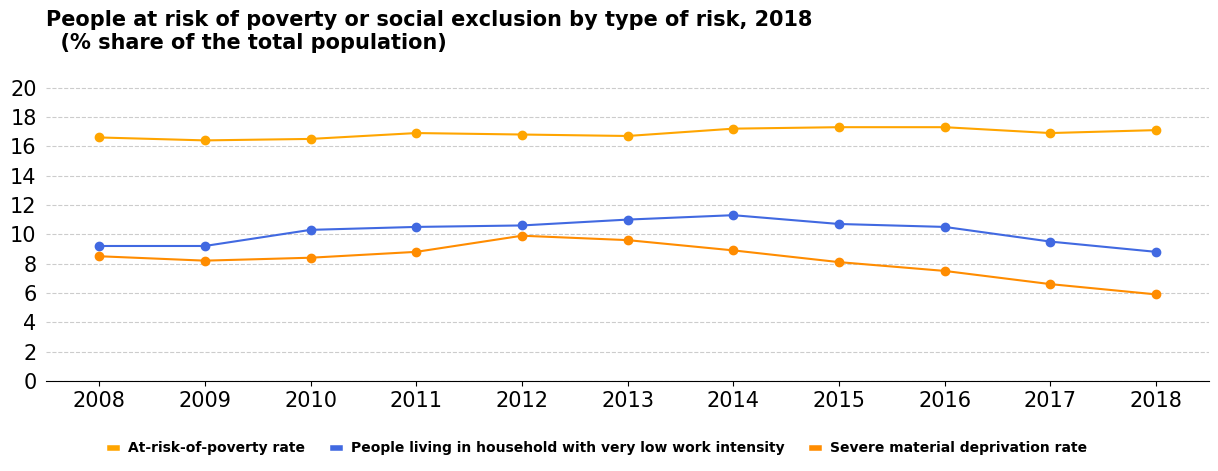

In [12]:

import numpy as np
from eurostatapiclient import EurostatAPIClient
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

#Set versions and formats, so far only the ones used here are availeable and call client
VERSION = 'v2.1'
FORMAT = 'json'
LANGUAGE = 'en'
client = EurostatAPIClient(VERSION, FORMAT, LANGUAGE)

legend_properties = {'weight':'bold','size':'10'}
ax_properties = {'fontsize': '15', 'weight':'bold'}

dataframe_5_query_total = 'ilc_li02?sinceTimePeriod=2008&precision=1&sex=T&indic_il=LI_R_MD60&unit=PC&age=TOTAL'
dataframe_5_query_lowork = 'ilc_lvhl11?sinceTimePeriod=2008&precision=1&sex=T&geo=EU&unit=PC_Y_LT60&age=Y_LT60'
dataframe_5_query_material = 'ilc_mddd11?sinceTimePeriod=2008&precision=1&sex=T&unit=PC&age=TOTAL'

dataframe_5_total =client.get_dataset(dataframe_5_query_total).to_dataframe()
dataframe_5_total =dataframe_5_total.loc[dataframe_5_total['geo'] == 'EU'].pivot(index = 'time',columns = 'age', values = 'values')
dataframe_5_lowork =client.get_dataset(dataframe_5_query_lowork).to_dataframe()
dataframe_5_lowork =dataframe_5_lowork.loc[dataframe_5_lowork['geo'] == 'EU'].dropna().groupby(by = 'time')['values'].sum()
dataframe_5_material = client.get_dataset(dataframe_5_query_material).to_dataframe()
dataframe_5_material =dataframe_5_material.loc[dataframe_5_material['geo'] == 'EU'].dropna().groupby(by = 'time')['values'].sum()

fig, ax = plt.subplots(figsize=(15, 4))
plt.style.use('default') # Set the aesthetic style of the plots

plt.ylim(0,21)
plt.yticks(np.arange(0, 21, step=2))
plt.plot(dataframe_5_total,color='orange', marker ='o' )
plt.plot(dataframe_5_lowork, color='royalblue', marker ='o')
plt.plot(dataframe_5_material , color='darkorange', marker ='o')

gold_line = Line2D([0], [0],lw = 4, color = 'orange', label='At-risk-of-poverty rate')
blue_line =Line2D([0], [0],lw = 4,color='royalblue', label='People living in household with very low work intensity')
orange_line =Line2D([0], [0],lw = 4,color='darkorange', label='Severe material deprivation rate')

leg= ax.legend(handles=[gold_line,blue_line, orange_line],frameon=False, loc=(0.05, -.26), ncol=3, prop=legend_properties,labelspacing=0.1, handlelength=0.5)

ax.grid(True, which = 'major', axis = 'y' , color ='grey', linestyle = '--', alpha = 0.4)
sns.despine(top=True, right=True, left=True, bottom=False)
ax.tick_params(axis = 'both',which = 'major' , labelsize = 15)
ax.tick_params(axis = "y", left = False)

ax.set_title('People at risk of poverty or social exclusion by type of risk, 2018 \n  (% share of the total population)' 
             , fontsize=15,fontweight='bold', horizontalalignment = 'left', x = 0, y =1.05)

# **Figure 6**
![Figure 6: At-risk-of-poverty rate and at-risk-of-poverty threshold, 2018 (% / thousand PPS)
](https://ec.europa.eu/eurostat/statistics-explained/images/e/ec/At-risk-of-poverty_rate_and_at-risk-of-poverty_threshold%2C_2018.png)
Figure 6: At-risk-of-poverty rate and at-risk-of-poverty threshold, 2018 (% / thousand PPS)

Source: Eurostat ([ilc_li02](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li02&lang=en)) and ([ilc_li01](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li01&lang=en))
# **Figure 7**
![Figure 7: At-risk-of-poverty rate - before and after - deducting housing costs, 2018 (% share of total population)](https://ec.europa.eu/eurostat/statistics-explained/images/0/05/At-risk-of-poverty_rate_-_before_and_after_-_deducting_housing_costs%2C_2018.png)
Figure 7: At-risk-of-poverty rate - before and after - deducting housing costs, 2018 (% share of total population)
Source: Eurostat ([ilc_li02](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li02&lang=en)) and ([ilc_li48](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li48&lang=en))
# **Figure 8**
![Figure 8: At-risk-of-poverty rate - before and after - social transfers, 2018 (% share of total population)
](https://ec.europa.eu/eurostat/statistics-explained/images/f/fe/At-risk-of-poverty_rate_-_before_and_after_-_social_transfers%2C_2018.png)
Figure 8: At-risk-of-poverty rate - before and after - social transfers, 2018 (% share of total population)
Source: Eurostat ([ilc_li02](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li02&lang=en)) and ([ilc_li10](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li10&lang=en))

# **Map 1**
![Map 1: At-risk-of-poverty rate anchored in 2008, 2008-2018 (percentage points difference, 2018 minus 2008)
](https://ec.europa.eu/eurostat/statistics-explained/images/7/7a/AROPE_2019_map1-1.png)

Map 1: At-risk-of-poverty rate anchored in 2008, 2008-2018 (percentage points difference, 2018 minus 2008)

Source: Eurostat ([ilc_li22b](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li22b&lang=en))

### Additional material

At this stage, it is up to you to extend the work presented in the notebook with further analysis/visualisation you deem relevant. 